<a href="https://www.nvidia.com/dli/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

<h1 align="center">Optimization and Deployment of TensorFlow Models with TensorRT</h1>




Welcome to the *Deep Learning Optimization and Deployment using TensorRT* lab! In this lab you will learn how to increase the throughput of your models and decrease their latency during the inference stage. We will utilize __TF-TRT__ as a high-performance inference engine optimizer and deployment tool for TensorFlow. 

### Course Objectives

After completing this course, you will be able to:

* Understand the fundamentals of optimization using TF-TRT
* Deploy deep learning models by reduced precision (FP32, FP16 and INT8) on the inference stage and calibrate the weights according to data distribution
* Benchmark classification and detection models over the desired dataset after optimization
* Implement custom operations to include non-supported operations


### Course Prerequisites

This lab, requires the students to have prior knowledge in Deep Learning, in addition to the following topics:

* Proficiency in programming, and experience in Python coding
* Mastery of TensorFlow framework

### Jupyter Notebook

Before we get started, there are a few items to consider on this jupyter notebook:

1. The notebook is being rendered on your browser, but the contents are being streamed by an interactive iPython kernel running on an AWS EC2 GPU enabled instance.

2. The notebook is composed of cells; cells can contain code which you can run, or they can hold text and/or images which are there for you to read.

3. You can execute code cells by clicking the ```Run``` icon in the menu, or via the following keyboard shortcuts ```Shift-Enter``` (run and advance) or ```Ctrl-Enter``` (run and stay in the current cell).

4. To interrupt cell execution, click the ```Stop``` button on the toolbar or navigate to the ```Kernel``` menu, and select ```Interrupt ```.

Run the following markdown cell and make sure your browser supports `web sockets` required to run this lab.


In [1]:
1 + 1  # i'm a code cell -- if you run me I'll perform some computations and show you their result below

2

This tutorial covers the following topics:

* [Introduction](#introduction)
* [Optimizing TensorFlow Models](#Optimizing_TensorFlow)
* [Cityscapes Dataset: an Application for Smart Cities](#dataset)
* [Importing a Model](#importing_model)
* [Stacking Images for Batch Inference](#stacking)
* [Batch Inference Before Optimization](#batch_inference)
* [Network Tranformation](network_transformation#)
* [Graph Optimization using `create_inference_graph`](#'graph_optimization_function)
* [Results Evaluation](#Results_evaluation)
* [Exercise 1: Choosing the Batch-Size](#exercise_1)
* [Exercise 2: Segment-Size Parameter Selection](#exercise_2)
* [INT8 Inference and Calibration](#inference)
* [Exercise 3: INT8 Reduced Precision and Calibration](#exercise_3)
* [Custom Operations](#custom_operations)
* [Custom Relu6 Code Sample](#custom_relu)
* [Exercise 4: SSD MobileNet Optimization](#exercise_4)
* [Exercise 5: Batch Inference](#exercise_5)
* [Summary](#summary)


<a id='introduction'></a>
## Introduction
---


### Optimization and Deployment



Deep learning models are applied to problems in a variety of domains including automotive, intelligent video analytics and live recommendation systems.  Most modern deep learning models have millions of parameters that formulate an optimization problem. In addition, live inference engines are required to process multiple data sources simultaneously (e.g. multiple camera inputs), resulting in demand for massive computational power. As the complexity and size of these models grow, the need for model optimization is inevitable.

Another factor stipulating a more delicate approach towards model deployment is __data growth__. It is estimated that by the year 2020, the digital data will outreach 30,000 Exabytes which requires deep learning models to be carefully designed to be able to handle such an intense growth. As an example, in image processing applications, not only the number of cameras is rapidly growing, but so is the image resolution.

<br/><br/>
<img src='images/4k.png' />
<p style="text-align: center;color:gray"> Figure 1. Current commercial state of the art video features resolutions up to 4k, roughly 3840x2160 pixels.</p>

<br/><br/>
TensorRT is designed to help deploy deep learning for these use-cases. With support for every major framework, TensorRT helps process large amounts of data with low latency through powerful optimizations, use of reduced precision, and efficient memory utilization.


<img src='images/GIE_Graphics_FINAL-1.png' />
<p style="text-align: center;color:gray"> Figure 2. TensorRT comprises of two stages, Model optimization (left) and TensorRT target runtime (right) </p>

TensorRT provides an optimization and deployment interface for deep learning frameworks and libraries and enables users to generate optimized models and consequently increase efficiency and performance of deep learning models and decrease the cost of deployment. TensorRT supports a variety of frameworks such as Caffe 2, Chainer, Microsoft Cognitive Toolkit, MxNet and PyTorch into TensorRT. In addition, TensorFlow and TensorRT are tightly integrated.

There are two phases in the use of TensorRT: __optimization__ and __real-time inference__. In the optimization phase, TensorRT performs optimizations on the network configuration and generates an optimized plan for computing the forward pass through the deep neural network. The plan is an optimized object code that can be serialized and stored in memory or on disk.

The real-time inference phase takes the form of a long running service or user application that accepts batches of input data, performs inference by executing the plan on the input data and returns batches of output data (classification, object detection, etc.). With TensorRT, you don’t need to install and run a deep learning framework on the deployment hardware. Discussion of the architecture and deployment of the inference service is not a topic of this lab; instead, we will focus on how to use TensorRT for optimizing TensorFlow models.


To start, let's run the following cell to get the TensorRT version running on this machine:

In [2]:
!dpkg -l | grep nvinfer
!ls

ii  libnvinfer-dev                                                   5.1.5-1+cuda10.0                                 amd64        TensorRT development libraries and headers
ii  libnvinfer-samples                                               5.1.5-1+cuda10.0                                 all          TensorRT samples and documentation
ii  libnvinfer5                                                      5.1.5-1+cuda10.0                                 amd64        TensorRT runtime libraries
classification	models			  README.md  tensorrt
images		nvidia_tf_trt_main.ipynb  temp	     Untitled.ipynb



While this lab revolves around TF-TRT, TensorRT provides an [ONNX parser] as well (https://docs.nvidia.com/deeplearning/sdk/tensorrt-api/python_api/parsers/Onnx/pyOnnx.html), which ingests a saved model, optimizes it, and returns the optimized model for applications using ONNX models.  __This method of optimization works outside the framework and is not part of this lab.__

<img src='images/fit.png' />
<p style="text-align: center;color:gray"> Figure 3. A common pipeline for ONNX model optimization </p>

In this lab, we focus on TensorRT integration with TensorFlow (__known as TF-TRT__) where the optimization process happens __within__  the TensorFlow framework. While the ONNX TensorRT optimization requires the whole graph to be supported and optimized, TF-TRT works on subgraphs of the original graph and allows TensorFlow to execute on the remaining section(s) of the graph. In practice, TF-TRT optimizes the __largest__ subgraphs possible in the TensorFlow graph. A larger size of the subgraph leads to a greater performance by optimizing more layers of the model. 

Based on the graph structure, the optimization may happen in different subsections of the graph and you can define the minimum size of layers to be optimized when calling the API.

__TF-TRT is part of TensorFlow installation binary and when you install TensorFlow-gpu, you will be able to use TensorRT as well.__

TF-TRT needs the following to deploy a classification neural network:

* A Graph definition object (GraphDef), and

* Trained weights (E.g. checkpoint saved file),

* In addition, you must define the batch size and specify the output layers. Later, we will see how to choose these parameters for a particular model to create a TensorRT optimized object
.

<a id='dataset'></a>
### Cityscapes Dataset: An Application for Smart Cities

In this lab, we are going to base our optimized models on the [Cityscapes ]( https://www.cityscapes-dataset.com) dataset. Cityscapes contains a diverse set of city side landscapes from several cities in Germany. There are 5000 annotated objects, making the dataset a great case-study for segmentation algorithms. There are also 20K annotated frames.

For the first part of this lab, we are going to analyze the frames using __classification__ models. While the objective is overly simplified, the aim is to focus on learning fundamentals of optimizing models using TF-TRT. Another reason for beginning with classification models is their high level of compatibility compared to detection and segmentations models.

 Within the second part of the lab, we focus on more realistic scenarios of multiple __object detection__ within each frame, which require implementing __custom operations__. The resulting models demonstrate potential applications in smart-city management, automotive and traffic handling. This same optimization methodology could be applied to models specific to other domains.





<a id='Optimizing_TensorFlow'></a>
## Optimizing TensorFlow Models
---

In this section, we will review how to import a trained model and run test images through a TensorFlow session. Later, we optimize the same model and compare the results. We assume the learner is familiar with Python and TensorFlow, however comments and code descriptions are provided when necessary.

When optimizing a TensorFlow model, TF-TRT can optimize either a subgraph or the entire graph definition. This capability allows the optimization procedure to be applied to the graph where possible and skip the non-supported graph segments. As a result, if the existing model contains a non-supported layer or operation, TensorFlow can still optimize the graph. 

Below, you can see a typical workflow of TF-TRT:
<br/>
<br/>
<br/>

<img src='images/pipeline.png' width='800px' />
<p style="text-align: center;color:gray"> Figure 4. TF-TRT optimization workflow </p>


To see the list of operations supported by TF-TRT visit the following link: [https://docs.nvidia.com/deeplearning/dgx/integrate-tf-trt/index.html#support-ops](https://docs.nvidia.com/deeplearning/dgx/integrate-tf-trt/index.html#support-ops)

If your model includes operations not listed in the link, the optimized model may still work fine, as it is designed to delegate those operations to TensorFlow.

<a id='importing_model'></a>
### Importing a Model

To begin, we must import the packages required for this lab.


In [3]:
from __future__ import absolute_import

%matplotlib inline

# Importing Matplotlib which is a plotting library for the Python programming
# language and its numerical mathematics extension NumPy

from matplotlib import pyplot as plt

# libraries to read json config files

import argparse
import json

# Helper function for downloading models and datasets

from tensorrt.helper import download_model, download_dataset
from tensorrt.helper import MODELS as models


# urllib2 for http downloads
try:
    import urllib2
except ImportError:
    import urllib.request as urllib2
    
    
# tensorflow libraries    
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt

# tqdm timing library
import tqdm
import pdb

# more common python libraries

from collections import namedtuple
from PIL import Image
import numpy as np
import time
import subprocess
import os
import glob
from os.path import join


# OpenCV library
import cv2

# more helper functions for detection tasks 

from tensorrt.graph_utils import force_nms_cpu as f_force_nms_cpu
from tensorrt.graph_utils import replace_relu6 as f_replace_relu6
from tensorrt.graph_utils import remove_assert as f_remove_assert

from google.protobuf import text_format
from object_detection.protos import pipeline_pb2, image_resizer_pb2
from object_detection import exporter

# resnet specific configuration parameters
from nets import resnet_v2



# classification tasl helper files

import shutil
import nets.nets_factory
import tensorflow.contrib.slim as slim
import official.resnet.imagenet_main
from preprocessing import inception_preprocessing, vgg_preprocessing
from classification.tf_trt_models.classification import download_classification_checkpoint, build_classification_graph

from nets import vgg
from tensorflow.python.platform import gfile

from datasets import imagenet
from tensorflow.contrib import slim

# inception specific configuration parameters

from nets import inception
from nets import inception_utils
from preprocessing import inception_preprocessing

In [4]:
import sys
print(sys.path)
import object_detection
print(object_detection.__file__)
import matplotlib

['/home/jylee/work/tensorrt_tutorials/nvidia_tftrt_dli_resource', '/home/jylee/work/tensorflow/models', '/home/jylee/work/tensorflow/models/research', '/home/jylee/work/tensorflow/models/research/slim', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/jylee/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/home/jylee/.local/lib/python3.6/site-packages/IPython/extensions', '/home/jylee/.ipython']
/home/jylee/work/tensorflow/models/research/object_detection/__init__.py


We will be using [TensorFlow Slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) library extensively to benchmark the optimization process. `Slim` is a lightweight library by which you can train and evaluate several widely used deep-learning models. It also provides pre-trained checkpoints that can be used/deployed without further ado.

In order to facilitate loading frozen models and measuring benchmarks of the models, we have included a helper file [classification_helper.py](../../../../edit/tasks/l-iv-07-v2/task/tensorrt/classification_helper.py) for you to review and get familiarized with the functionality before proceeding to the next step.


<a id='stacking'></a>
### Stacking Images for Batch Inference

To process each image, we need to convert them into numpy arrays. __Image.open__ is a convenient function to read raw  images:

In [5]:
def get_image(image_path, width, height):
    """Getting the image in Tensor form
    
    image_path: absolute path of the image
    width:      desired width after transformation
    height:     desired height after transformation
    Returns numpy array of resized image
    """
    
    return np.array(Image.open(image_path).resize((width, height)))


One way to parallelize the computation at the inference stage is to use __batch inference__. 



TensorFlow uses CUDA in order to optimize the GPU memory management, and since typically memory IO is a bottleneck during the inference, it is wise to work with batch sizes that maximize the throughput of your model. Batch sizes of multiples of 32 usually provide optimal stacks of images for V100 and Tesla T4 GPUs to process. This is due to the size of especial kernels that TensorRT uses for matrix multiplications.

Note that different batch sizes have no effect on other KPIs (like acuuracy) but the overal throughput. When optimizing your neural network model using TensorRT, you would need to provide the batch size for which you would like your models optimized. The `get_directory_images` function is used to stack the image arrays for inference:


In [6]:
def get_directory_images(image_directory, 
                         batch_size, 
                         image_width,
                         image_height):
    """ get the image batch

    image_directory: the directory containing the image list
    batch_size: maximum number of images to stack
    image_width: width of the images after pre-processing to match the model input
    image_height: height of the images after pre-processing to match the model input
    
    Returns the image batch array
    """
    outputs = np.empty([0,image_width, image_height, 3])
    count = 0
    image = []
    for root, dirs, files in os.walk(image_directory):  
        # read up to a specified number of files
        for filename in files:
        # if number of images is bigger than then batch size stop there!
            if count == batch_size:
                break
            file_path=os.path.join(root, filename)
            outputs = np.concatenate([outputs, get_image(file_path, image_width, image_height)[None, ...]])
            count = count + 1
    return outputs

To work with classification models, we need an implementation of the model which describes the layers and operations defining the architecture of the deep network. In addition, we need to initialize the model weights with pre-trained values. One way to save model weights is to take a snapshot of the model during training called `checkpoints` and reuse the on later runs. TensorFlow's `official` and `slim` repositories contain such snapshots for download. 



The `download_classification_checkpoint` function included in the helper file [classification.py](../../../../edit/tasks/l-iv-07-v2/task/classification/tf_trt_models/classification.py) is used below to load the checkpoints. Later, we will use the downloaded `checkpoint` file to retrieve the weights.

You may choose your model from the following classification models:
 
* mobilenet_v1_0p25_128
* mobilenet_v1_0p5_160
* mobilenet_v1_1p0_224
* vgg_16
* vgg_19
* inception_v1
* inception_v2
* inception_v3
* inception_v4
* inception_resnet_v2
* resnet_v1_50
* resnet_v1_101
* resnet_v1_152
* resnet_v2_50
* resnet_v2_101
* resnet_v2_152

<a id='batch_inference'></a>
### Batch Inference Before Optimization


Let's take a look at how our model performs prior to graph optimization. We use resnet_v2_152 as an example. Later, you will be asked to benchmark other models as exercise.

First, let's define the parameters describing the model name and paths and also the `label` file and `image` paths:



In [7]:
MODEL = 'resnet_v2_152'
CHECKPOINT_PATH = 'resnet_v2_152.ckpt'
#number of classes for a certain dataset
NUM_CLASSES = 1001
LABELS_PATH = 'classification/examples/classification/data/imagenet_labels_%d.txt' % NUM_CLASSES
image_paths = './tensorrt/coco/CS'

Below, we are going to download the checkpoint. Depending on the model you choose, it may take a few minutes for the process to complete.

In [8]:
checkpoint_path = download_classification_checkpoint(MODEL, 'classification/data')

Once the checkpoint is downloaded, we need to obtain the graph itself and initialize the weights using the checkpoint. To accomplish this, we are using another helper function named `build_classification_graph` defined in [classification.py](../../../../edit/tasks/l-iv-07-v2/task/classification/tf_trt_models/classification.py). A frozen graph combines the weights and model architecture to build a complete graph. Note that you can also save the frozen graph on disk using graph's `SerializeToString()` method.

__Note:__ Some TensorFlow operations may throw `WARNING` messages, many of which are related to internal functionalities of __TensorFlow__ and __slim__ and may safely be ignored.

In [9]:
frozen_graph, input_names, output_names = build_classification_graph(
    model=MODEL,
    checkpoint=checkpoint_path,
    num_classes=NUM_CLASSES
)

Instructions for updating:
Colocations handled automatically by placer.


W0709 17:47:13.233174 139836305807168 deprecation.py:323] From /home/jylee/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0709 17:47:17.074731 139836305807168 deprecation.py:323] From /home/jylee/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from classification/data/resnet_v2_152/resnet_v2_152.ckpt


I0709 17:47:17.076101 139836305807168 saver.py:1270] Restoring parameters from classification/data/resnet_v2_152/resnet_v2_152.ckpt


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


W0709 17:47:18.417752 139836305807168 deprecation.py:323] From /home/jylee/work/tensorrt_tutorials/nvidia_tftrt_dli_resource/classification/tf_trt_models/classification.py:215: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


W0709 17:47:18.418890 139836305807168 deprecation.py:323] From /home/jylee/.local/lib/python3.6/site-packages/tensorflow/python/framework/graph_util_impl.py:245: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


INFO:tensorflow:Froze 816 variables.


I0709 17:47:18.775537 139836305807168 graph_util_impl.py:268] Froze 816 variables.


INFO:tensorflow:Converted 816 variables to const ops.


I0709 17:47:18.953631 139836305807168 graph_util_impl.py:301] Converted 816 variables to const ops.




The `frozen_graph` object contains the serialized GraphDef protocol buffer. Next, we need to extract individual objects of the graph definition into `Operation` and `Tensor objects` using TensorFlow's [import_graph_def](https://www.tensorflow.org/api_docs/python/tf/graph_util/import_graph_def) command. Also, note that since we are going to call this function frequently, we need to erase the default graph stack and remove the default graph using [reset_default_graph](https://www.tensorflow.org/api_docs/python/tf/reset_default_graph) function:



In [10]:
tf.reset_default_graph()
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)
tf.import_graph_def(frozen_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_output = tf_sess.graph.get_tensor_by_name(output_names[0] + ':0')
width = int(tf_input.shape.as_list()[1])
height = int(tf_input.shape.as_list()[2])

Let's take a look at the nodes of the loaded graph. Note that depending on the model, the list may become very long. When you are optimizing your model using the `create_inference_graph` function, you would need to provide the network output names to the function. You can use this code snippet to find the output names.

In [11]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['input',
 'truediv/y',
 'truediv',
 'sub/y',
 'sub',
 'mul/x',
 'mul',
 'resnet_v2_152/Pad/paddings',
 'resnet_v2_152/Pad',
 'resnet_v2_152/conv1/weights',
 'resnet_v2_152/conv1/weights/read',
 'resnet_v2_152/conv1/biases',
 'resnet_v2_152/conv1/biases/read',
 'resnet_v2_152/conv1/Conv2D',
 'resnet_v2_152/conv1/BiasAdd',
 'resnet_v2_152/pool1/MaxPool',
 'resnet_v2_152/block1/unit_1/bottleneck_v2/preact/gamma',
 'resnet_v2_152/block1/unit_1/bottleneck_v2/preact/gamma/read',
 'resnet_v2_152/block1/unit_1/bottleneck_v2/preact/beta',
 'resnet_v2_152/block1/unit_1/bottleneck_v2/preact/beta/read',
 'resnet_v2_152/block1/unit_1/bottleneck_v2/preact/moving_mean',
 'resnet_v2_152/block1/unit_1/bottleneck_v2/preact/moving_mean/read',
 'resnet_v2_152/block1/unit_1/bottleneck_v2/preact/moving_variance',
 'resnet_v2_152/block1/unit_1/bottleneck_v2/preact/moving_variance/read',
 'resnet_v2_152/block1/unit_1/bottleneck_v2/preact/FusedBatchNorm',
 'resnet_v2_152/block1/unit_1/bottleneck_v2/preact/Rel

In order to test our model, we are going to define the `run_test` function which inputs the batch size, and using methods we already covered, imports a stack of images and runs the inference with the loaded graph. Next, the resulting classes are sorted increasingly based on their scores and their top 5 are printed.

In [12]:
def run_test(batch_size=32):
    print("Getting list of test images...")
    inputs = get_directory_images(image_paths,batch_size,width, height)
    
    print("Reading labels...")
    with open(LABELS_PATH, 'r') as f:
        labels = f.readlines()

    print("Running the session over a batch size of: ", batch_size)
    tic = time.time()
    output = tf_sess.run(tf_output, feed_dict={
        tf_input: inputs
    })
    toc = time.time()
    t_diff = toc - tic
    print("TOTAL TIME:", t_diff) 


    print("Getting the resulted classes:")
    for index in range(batch_size):
        print(index)
        
        plt.figure(figsize=(6,3))
        plt.imshow(inputs[index,...].astype(np.uint8))
        plt.axis('off')
        plt.show()
        
        scores = output[index]
        top5_idx = scores.argsort()[::-1][0:5]

        for i in top5_idx:
            print('(%3f) %s' % (scores[i], labels[i]))

Finally, we are going to call the `run_test` method over a batch size of 32 to observe how this model performs before optimization. 

Getting list of test images...
Reading labels...
Running the session over a batch size of:  32
TOTAL TIME: 3.1487789154052734
Getting the resulted classes:
0


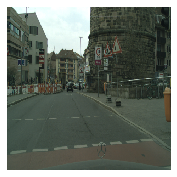

(0.691590) water tower

(0.076010) planetarium

(0.021800) traffic light, traffic signal, stoplight

(0.016956) dome

(0.016577) cab, hack, taxi, taxicab

1


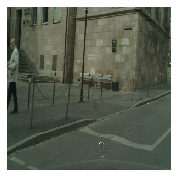

(0.287385) monastery

(0.175037) prison, prison house

(0.091257) vault

(0.040951) mosque

(0.037198) traffic light, traffic signal, stoplight

2


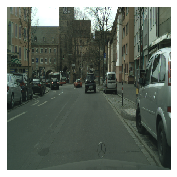

(0.215213) cab, hack, taxi, taxicab

(0.115824) traffic light, traffic signal, stoplight

(0.059736) minivan

(0.058755) trolleybus, trolley coach, trackless trolley

(0.058198) police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria

3


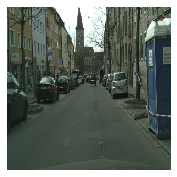

(0.559031) streetcar, tram, tramcar, trolley, trolley car

(0.281308) trolleybus, trolley coach, trackless trolley

(0.011290) traffic light, traffic signal, stoplight

(0.008210) passenger car, coach, carriage

(0.004862) ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin

4


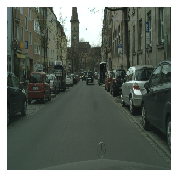

(0.262506) traffic light, traffic signal, stoplight

(0.172040) parking meter

(0.095042) street sign

(0.056483) cab, hack, taxi, taxicab

(0.055906) triumphal arch

5


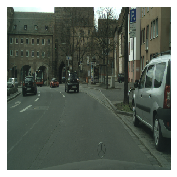

(0.105588) police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria

(0.095883) traffic light, traffic signal, stoplight

(0.069000) minibus

(0.057321) triumphal arch

(0.050517) street sign

6


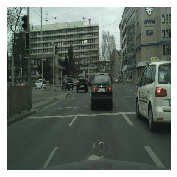

(0.136129) traffic light, traffic signal, stoplight

(0.125169) garbage truck, dustcart

(0.106242) police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria

(0.051033) minibus

(0.046478) minivan

7


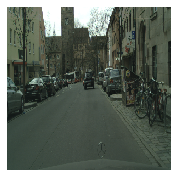

(0.091213) triumphal arch

(0.088135) traffic light, traffic signal, stoplight

(0.063723) moped

(0.058709) street sign

(0.047500) parking meter

8


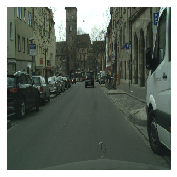

(0.269769) minibus

(0.054642) streetcar, tram, tramcar, trolley, trolley car

(0.044685) police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria

(0.041412) cab, hack, taxi, taxicab

(0.039638) traffic light, traffic signal, stoplight

9


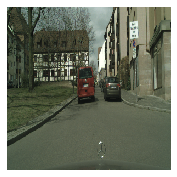

(0.682464) fire engine, fire truck

(0.110769) trolleybus, trolley coach, trackless trolley

(0.042443) streetcar, tram, tramcar, trolley, trolley car

(0.026155) ambulance

(0.023130) bubble

10


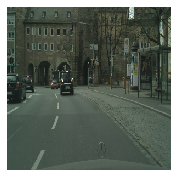

(0.140650) traffic light, traffic signal, stoplight

(0.066244) cab, hack, taxi, taxicab

(0.065727) streetcar, tram, tramcar, trolley, trolley car

(0.040996) Model T

(0.034864) triumphal arch

11


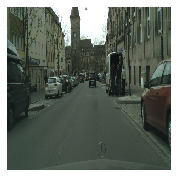

(0.183971) cab, hack, taxi, taxicab

(0.134025) traffic light, traffic signal, stoplight

(0.095552) parking meter

(0.077219) streetcar, tram, tramcar, trolley, trolley car

(0.067133) trolleybus, trolley coach, trackless trolley

12


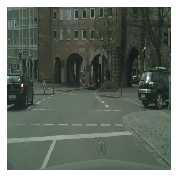

(0.144944) triumphal arch

(0.064330) traffic light, traffic signal, stoplight

(0.045693) mosque

(0.042234) cab, hack, taxi, taxicab

(0.031711) streetcar, tram, tramcar, trolley, trolley car

13


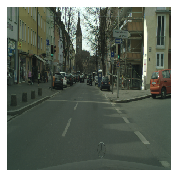

(0.244661) cab, hack, taxi, taxicab

(0.130117) fire engine, fire truck

(0.111017) ambulance

(0.109356) traffic light, traffic signal, stoplight

(0.042763) street sign

14


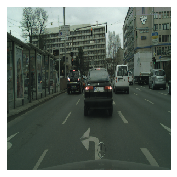

(0.118839) traffic light, traffic signal, stoplight

(0.103782) trolleybus, trolley coach, trackless trolley

(0.039908) cab, hack, taxi, taxicab

(0.027575) street sign

(0.026860) garbage truck, dustcart

15


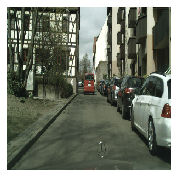

(0.247734) cab, hack, taxi, taxicab

(0.075354) shopping cart

(0.057902) parking meter

(0.053378) traffic light, traffic signal, stoplight

(0.022776) triumphal arch

16


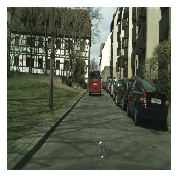

(0.484960) streetcar, tram, tramcar, trolley, trolley car

(0.051306) parking meter

(0.042970) trolleybus, trolley coach, trackless trolley

(0.041903) cab, hack, taxi, taxicab

(0.037732) mailbox, letter box

17


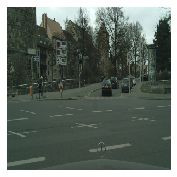

(0.525476) traffic light, traffic signal, stoplight

(0.048163) cab, hack, taxi, taxicab

(0.031287) streetcar, tram, tramcar, trolley, trolley car

(0.030684) street sign

(0.020888) obelisk

18


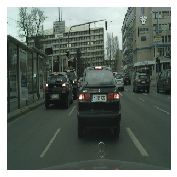

(0.265002) traffic light, traffic signal, stoplight

(0.139027) police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria

(0.101620) cab, hack, taxi, taxicab

(0.034767) street sign

(0.034158) streetcar, tram, tramcar, trolley, trolley car

19


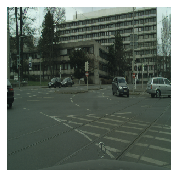

(0.189993) streetcar, tram, tramcar, trolley, trolley car

(0.147455) traffic light, traffic signal, stoplight

(0.135586) trolleybus, trolley coach, trackless trolley

(0.123010) cab, hack, taxi, taxicab

(0.096135) minivan

20


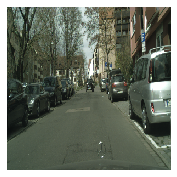

(0.202894) minivan

(0.110953) traffic light, traffic signal, stoplight

(0.103735) cab, hack, taxi, taxicab

(0.094553) parking meter

(0.032236) shopping cart

21


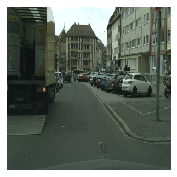

(0.199260) trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi

(0.069736) garbage truck, dustcart

(0.065811) streetcar, tram, tramcar, trolley, trolley car

(0.041181) traffic light, traffic signal, stoplight

(0.032611) moving van

22


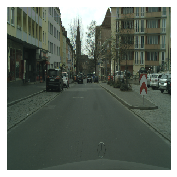

(0.187365) traffic light, traffic signal, stoplight

(0.126800) cab, hack, taxi, taxicab

(0.102238) streetcar, tram, tramcar, trolley, trolley car

(0.083460) parking meter

(0.032350) motor scooter, scooter

23


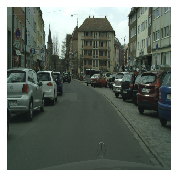

(0.207545) traffic light, traffic signal, stoplight

(0.101696) parking meter

(0.066731) cab, hack, taxi, taxicab

(0.065518) street sign

(0.039832) streetcar, tram, tramcar, trolley, trolley car

24


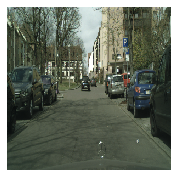

(0.774076) traffic light, traffic signal, stoplight

(0.042441) parking meter

(0.029520) triumphal arch

(0.022744) street sign

(0.016160) bubble

25


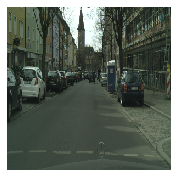

(0.374277) streetcar, tram, tramcar, trolley, trolley car

(0.147928) traffic light, traffic signal, stoplight

(0.141060) trolleybus, trolley coach, trackless trolley

(0.033858) parking meter

(0.032555) cab, hack, taxi, taxicab

26


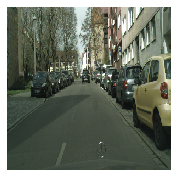

(0.876681) cab, hack, taxi, taxicab

(0.040547) parking meter

(0.012021) traffic light, traffic signal, stoplight

(0.004451) street sign

(0.004134) motor scooter, scooter

27


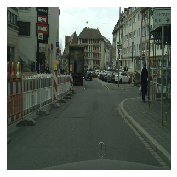

(0.443999) streetcar, tram, tramcar, trolley, trolley car

(0.076852) traffic light, traffic signal, stoplight

(0.024589) jinrikisha, ricksha, rickshaw

(0.023314) unicycle, monocycle

(0.020462) cab, hack, taxi, taxicab

28


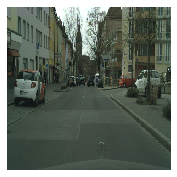

(0.249131) streetcar, tram, tramcar, trolley, trolley car

(0.181656) triumphal arch

(0.073842) traffic light, traffic signal, stoplight

(0.043113) minibus

(0.035477) cab, hack, taxi, taxicab

29


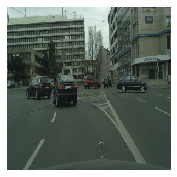

(0.348067) minivan

(0.092120) traffic light, traffic signal, stoplight

(0.089728) police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria

(0.088708) minibus

(0.087861) cab, hack, taxi, taxicab

30


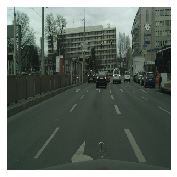

(0.239783) fire engine, fire truck

(0.222405) cab, hack, taxi, taxicab

(0.107149) streetcar, tram, tramcar, trolley, trolley car

(0.061430) limousine, limo

(0.034056) garbage truck, dustcart

31


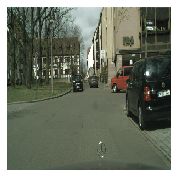

(0.220694) bubble

(0.142922) traffic light, traffic signal, stoplight

(0.068389) street sign

(0.042388) minivan

(0.034192) parking meter



In [13]:
run_test(32)

__Note:__ Due to operations like initializing memory allocators and GPU initialization, the first run is relatively slower and should not be benchmarked. To get more accurate comparison, you need to either discard the first run of the inference process or average the time over many runs.

Take a note of the `TOTAL TIME`, as we are going to compare it to post-optimization graph in the next section.


<a id='network_transformation'></a>
### Network Transformation

In this section we provide a brief overview of the graph optimization procedure by TensorRT. 
TensorRT performs several important transformations and optimizations to the neural network graph. First, layers with unused outputs are eliminated to avoid unnecessary computation. Next, where possible convolution, bias, and ReLU layers are fused to form a single layer. Figure 5 shows a typical convolutional network before optimization:

<img width="700px" src='images/network_optimization.png' />
<p style="text-align: center;color:gray"> Figure 5. An example convolutional  model with multiple convolutional and activation layers before optimization</p>

Figure 6 shows the result of this vertical layer fusion on the original network from Figure 5 (fused layers are labeled CBR in Figure 6).  Layer fusion improves the efficiency of running TensorRT-optimized networks on the GPU.

<img width="600px" src='images/network_vertical_fusion.png' />
<p style="text-align: center;color:gray"> Figure 6. Fusing blocks into a single layer </p>

Another transformation is horizontal layer fusion, or layer aggregation, along with the required division of aggregated layers to their respective outputs, as Figure 7 shows. Horizontal layer fusion improves performance by combining layers that take the same source tensor and apply the same operations with similar parameters, resulting in a single larger layer for higher computational efficiency. The example in Figure 7 shows the combination of 3 1×1 CBR layers from Figure 6 that take the same input into a single larger 1×1 CBR layer. Note that the output of this layer must be disaggregated to feed into the different subsequent layers from the original input graph.

<img width="600px" src='images/network_horizontal_fusion.png' />
<p style="text-align: center;color:gray"> Figure 7. Horizontal layer fusion </p>

TensorRT performs its transformations during the build phase transparently to the API user after the TensorRT parser reads in the trained network and configuration file.

<a id='graph_optimization_function'></a>
### Graph Optimization using `create_inference_graph`
---
 
In this section, we are using TF-TRT API (`create_inference_graph`) to optimize the `GraphDef` object of our model. We are going to review the most important parameters of the function. For a complete list of parameters please visit [https://docs.nvidia.com/deeplearning/dgx/integrate-tf-trt/index.html](https://docs.nvidia.com/deeplearning/dgx/integrate-tf-trt/index.html).

```
def create_inference_graph(input_graph_def,
                           outputs,
                           max_batch_size=1,
                           max_workspace_size_bytes=2 << 20,
                           precision_mode="fp32",
                           minimum_segment_size=3,
                           is_dynamic_op=False,
                           maximum_cached_engines=1,
                           cached_engine_batches=[]
                           rewriter_config=None,
                           input_saved_model_dir=None,
                           input_saved_model_tags=None,
                           output_saved_model_dir=None,
                           session_config=None)
  ```
  
where:

* __input_graph_def__:  This parameter is the GraphDef object that contains the model to be transformed.

* __outputs__: This parameter lists the output nodes in the graph. Tensors which are not marked as outputs are considered to be transient values that may be optimized away by the builder.

* __max_batch_size__: This parameter is the maximum batch size that specifies the batch size for which TensorRT will optimize. At runtime, a smaller batch size may be chosen. At runtime, larger batch size is not supported.

* __max_workspace_size_bytes__: TensorRT operators often require temporary workspace. This parameter limits the maximum size that any layer in the network can use. If insufficient scratch is provided, it is possible that TensorRT may not be able to find an implementation for a given layer.

* __precision_mode__: This parameter sets the precision mode; which can be one of fp32, fp16, or int8. Precision lower than FP32, meaning FP16 and INT8, would improve the performance of inference. The FP16 mode uses Tensor Cores or half precision hardware instructions, if possible. The INT8 precision mode uses integer hardware instructions.

* __minimum_segment_size__: This parameter determines the minimum number of TensorFlow nodes in a TensorRT engine, which means the TensorFlow subgraphs that have fewer nodes than this number will not be converted to TensorRT. Therefore, in general smaller numbers such as 5 are preferred. This can also be used to change the minimum number of nodes in the optimized INT8 engines to change the final optimized graph to fine tune result accuracy.

Below, we call `create_inference_graph` to optimize the graph.

In [14]:
# you may choose FP16 and FP32 precision modes. 
# INT8 involves additional steps that will be discussed later in Exercise 3.
p_mode = 'FP16'

trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=32,
    max_workspace_size_bytes=1 << 25,
    precision_mode=p_mode,
    minimum_segment_size=50
)

W0709 17:47:51.468345 139836305807168 tf_logging.py:161] TensorRT mismatch. Compiled against version 5.0.2, but loaded 5.1.5. Things may not work


We need to reset the graph again prior to replacing the existing graph

In [15]:
tf.reset_default_graph()
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)
tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_output = tf_sess.graph.get_tensor_by_name(output_names[0] + ':0')

width = int(tf_input.shape.as_list()[1])
height = int(tf_input.shape.as_list()[2])

With the new graph replaced, let's take a look at the active graph's node structure:

In [16]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['input', 'TRTEngineOp_0', 'scores']

Depending on the model, the output should vary from what we saw before and may look like:

```
['input',
 'sub/y',
 'mul/x',
 'resnet_v2_152/Pad/paddings',
 'ConstantFolding/truediv_recip',
 'PermConstNHWCToNCHW-LayoutOptimizer',
 'truediv',
 'sub',
 'mul',
 'resnet_v2_152/Pad',
 'resnet_v2_152/conv1/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer',
 'resnet_v2_152/my_trt_op_0',
 'resnet_v2_152/SpatialSqueeze',
 'scores']
```

As you see some of the layers have been replaced with TRT layers (postfixed by LayoutOptimizer). Now let's run the test again and benchmark the new model's performance:

Getting list of test images...
Reading labels...
Running the session over a batch size of:  32
TOTAL TIME: 0.3631784915924072
Getting the resulted classes:
0


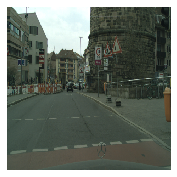

(0.722694) water tower

(0.068547) planetarium

(0.022428) traffic light, traffic signal, stoplight

(0.016864) bucket, pail

(0.015176) cab, hack, taxi, taxicab

1


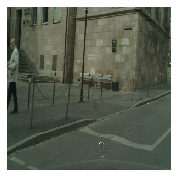

(0.207539) monastery

(0.188966) prison, prison house

(0.070611) bubble

(0.065305) vault

(0.041510) parking meter

2


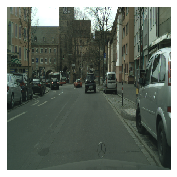

(0.232803) cab, hack, taxi, taxicab

(0.106585) traffic light, traffic signal, stoplight

(0.063150) police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria

(0.055947) minivan

(0.053177) trolleybus, trolley coach, trackless trolley

3


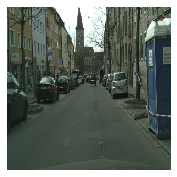

(0.508223) streetcar, tram, tramcar, trolley, trolley car

(0.244802) trolleybus, trolley coach, trackless trolley

(0.018440) traffic light, traffic signal, stoplight

(0.015589) ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin

(0.011721) mailbox, letter box

4


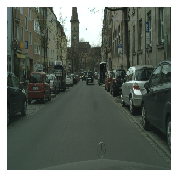

(0.263681) traffic light, traffic signal, stoplight

(0.155010) parking meter

(0.111214) street sign

(0.064366) cab, hack, taxi, taxicab

(0.046908) triumphal arch

5


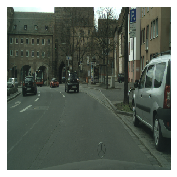

(0.143469) police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria

(0.087019) traffic light, traffic signal, stoplight

(0.066981) minibus

(0.050166) street sign

(0.043585) triumphal arch

6


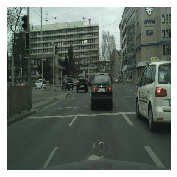

(0.136376) garbage truck, dustcart

(0.134262) traffic light, traffic signal, stoplight

(0.118949) police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria

(0.050170) minibus

(0.047872) minivan

7


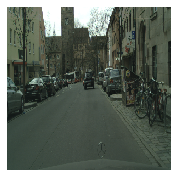

(0.103248) traffic light, traffic signal, stoplight

(0.084598) triumphal arch

(0.069047) moped

(0.063361) street sign

(0.047641) cab, hack, taxi, taxicab

8


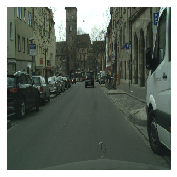

(0.233995) minibus

(0.054079) streetcar, tram, tramcar, trolley, trolley car

(0.047539) parking meter

(0.042948) traffic light, traffic signal, stoplight

(0.042614) cab, hack, taxi, taxicab

9


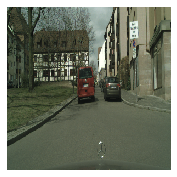

(0.704775) fire engine, fire truck

(0.107240) trolleybus, trolley coach, trackless trolley

(0.041183) streetcar, tram, tramcar, trolley, trolley car

(0.024688) ambulance

(0.019993) bubble

10


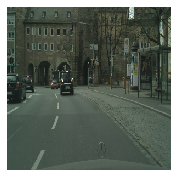

(0.106471) traffic light, traffic signal, stoplight

(0.065084) cab, hack, taxi, taxicab

(0.055236) streetcar, tram, tramcar, trolley, trolley car

(0.044384) Model T

(0.030744) limousine, limo

11


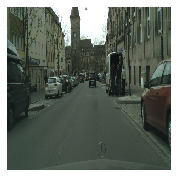

(0.198737) cab, hack, taxi, taxicab

(0.122917) traffic light, traffic signal, stoplight

(0.102301) streetcar, tram, tramcar, trolley, trolley car

(0.076321) parking meter

(0.065026) trolleybus, trolley coach, trackless trolley

12


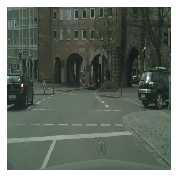

(0.164997) triumphal arch

(0.059992) traffic light, traffic signal, stoplight

(0.051515) mosque

(0.038282) cab, hack, taxi, taxicab

(0.032363) streetcar, tram, tramcar, trolley, trolley car

13


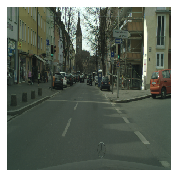

(0.326972) fire engine, fire truck

(0.134189) cab, hack, taxi, taxicab

(0.089739) traffic light, traffic signal, stoplight

(0.068270) ambulance

(0.057714) garbage truck, dustcart

14


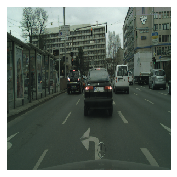

(0.114075) traffic light, traffic signal, stoplight

(0.099498) trolleybus, trolley coach, trackless trolley

(0.044498) cab, hack, taxi, taxicab

(0.030944) garbage truck, dustcart

(0.029183) street sign

15


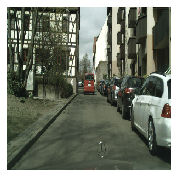

(0.279033) cab, hack, taxi, taxicab

(0.069457) shopping cart

(0.054305) parking meter

(0.050420) traffic light, traffic signal, stoplight

(0.022113) street sign

16


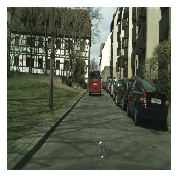

(0.464504) streetcar, tram, tramcar, trolley, trolley car

(0.059055) parking meter

(0.048199) cab, hack, taxi, taxicab

(0.041550) trolleybus, trolley coach, trackless trolley

(0.036668) mailbox, letter box

17


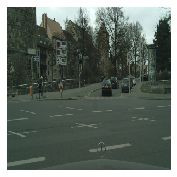

(0.530970) traffic light, traffic signal, stoplight

(0.047126) cab, hack, taxi, taxicab

(0.038765) street sign

(0.032516) streetcar, tram, tramcar, trolley, trolley car

(0.019416) trolleybus, trolley coach, trackless trolley

18


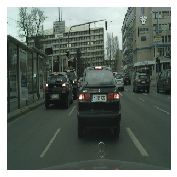

(0.252095) traffic light, traffic signal, stoplight

(0.168589) police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria

(0.097954) cab, hack, taxi, taxicab

(0.039732) street sign

(0.038061) trolleybus, trolley coach, trackless trolley

19


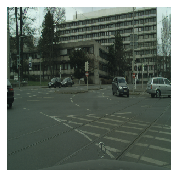

(0.176500) traffic light, traffic signal, stoplight

(0.152153) cab, hack, taxi, taxicab

(0.145185) streetcar, tram, tramcar, trolley, trolley car

(0.134274) trolleybus, trolley coach, trackless trolley

(0.108739) minivan

20


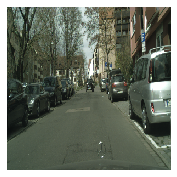

(0.216599) minivan

(0.109767) cab, hack, taxi, taxicab

(0.093158) traffic light, traffic signal, stoplight

(0.079372) parking meter

(0.032447) shopping cart

21


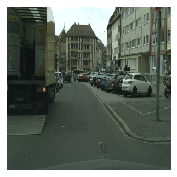

(0.195316) trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi

(0.089422) garbage truck, dustcart

(0.065168) streetcar, tram, tramcar, trolley, trolley car

(0.035431) moving van

(0.028359) traffic light, traffic signal, stoplight

22


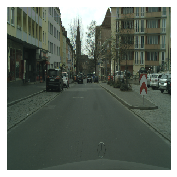

(0.175740) traffic light, traffic signal, stoplight

(0.115253) cab, hack, taxi, taxicab

(0.099743) parking meter

(0.094435) streetcar, tram, tramcar, trolley, trolley car

(0.027375) street sign

23


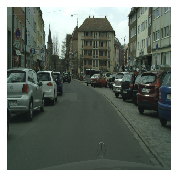

(0.210633) traffic light, traffic signal, stoplight

(0.098722) parking meter

(0.080890) street sign

(0.066279) cab, hack, taxi, taxicab

(0.033327) streetcar, tram, tramcar, trolley, trolley car

24


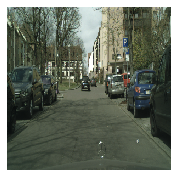

(0.702203) traffic light, traffic signal, stoplight

(0.050079) bubble

(0.047045) parking meter

(0.032842) street sign

(0.024694) triumphal arch

25


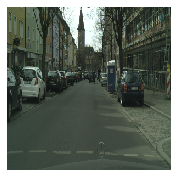

(0.399220) streetcar, tram, tramcar, trolley, trolley car

(0.163839) trolleybus, trolley coach, trackless trolley

(0.132164) traffic light, traffic signal, stoplight

(0.032770) cab, hack, taxi, taxicab

(0.032262) parking meter

26


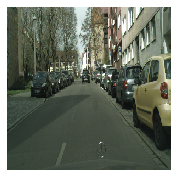

(0.865870) cab, hack, taxi, taxicab

(0.044826) parking meter

(0.016235) traffic light, traffic signal, stoplight

(0.005744) street sign

(0.003723) shopping cart

27


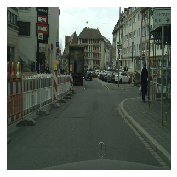

(0.378880) streetcar, tram, tramcar, trolley, trolley car

(0.111560) unicycle, monocycle

(0.070360) traffic light, traffic signal, stoplight

(0.029560) jinrikisha, ricksha, rickshaw

(0.018212) parking meter

28


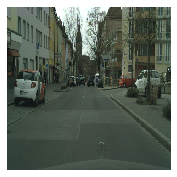

(0.249622) streetcar, tram, tramcar, trolley, trolley car

(0.174264) triumphal arch

(0.068510) traffic light, traffic signal, stoplight

(0.040909) cab, hack, taxi, taxicab

(0.038732) minibus

29


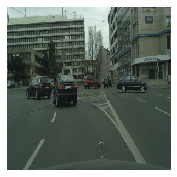

(0.336599) minivan

(0.099498) traffic light, traffic signal, stoplight

(0.093106) police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria

(0.088496) cab, hack, taxi, taxicab

(0.076587) minibus

30


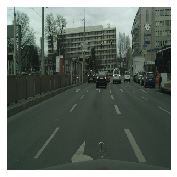

(0.294498) cab, hack, taxi, taxicab

(0.160742) fire engine, fire truck

(0.127655) streetcar, tram, tramcar, trolley, trolley car

(0.070774) limousine, limo

(0.041769) traffic light, traffic signal, stoplight

31


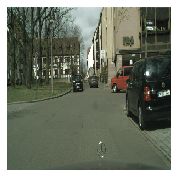

(0.343690) bubble

(0.106055) traffic light, traffic signal, stoplight

(0.044557) street sign

(0.039168) minivan

(0.022492) trolleybus, trolley coach, trackless trolley



In [17]:
run_test(32)

<a id='Results_evaluation'></a>
### Results Evaluation

After ignoring the first run, with the `resnet_v2_152` model, you should see a performance improvement of ~400% for a batch size of 32 and the main resulting classes remain the same as before optimization. Remember that the image aspect ratios are not maintained in this implementation, impacting the overall class quality (cropping the image in a real-world scenario is a potential solution), however what should be perceived here is the fact that the highest probability classification results are regenerated optimized model. Later in Exercise 2, you will see improved results by utilizing the VGG 19 model.

### 
<img width="800px" src='images/accuracy.png' />
<p style="text-align: center;color:gray"> Figure 8. comparison of inference times. left: before optimization. right: after optimization </p>



<a id='exercise_1'></a>
### Exercise 1: Choosing the Batch-Size
---

One of the important parameters of the optimization phase is the `max_batch_size`. While during inference, you may choose a different batch size to stack your images, the best performance is achieved when the exact same number as the max_batch_size is used. A smaller batch size may lead to poor performance and might significantly decrease the efficiency of your model. Larger numbers are __not__ supported by TensorRT. In this exercise, we are going to examine this parameter.

Compare the inference time for 8, 16 and 32 batch sizes and their combinations with FP16 and FP32 precision modes. 

In [ ]:
# PERFORM THE COMPARISON HERE (total inference time):

Batch \ Precision |
size              |      FP16             FP32
------------------------------------------------------------
                  |
8                 |
                  |
16                |
                  |
32                |
                  |

<a id='exercise_2'></a>
### Exercise 2: Segment-Size Parameter Selection
---

The success of a TRT optimization task is also dependent on the architecture of the model. The more supporting layers comprising the model, the greater number of TRT layers generated and consequently the higher performance is achieved. Also, `minimum_segment_size` parameter determines when to generate the TRT layers based on the consequent number of supporting layers.  In this exercise you are asked to optimize the  __vgg_19__ and __inception_v4__ models varying `minimum_segment_size` to maximize throughput (__on FP16 mode only__). You can achieve this by setting the `MODEL` and `CHECKPOINT_PATH` parameters together with changing the __create_inference_graph__'s `minimum_segment_size` parameter:

In [ ]:
# PERFORM THE COMPARISON HERE (total inference time - FP16 only):

Model \ Segment   |
           size   |      1             5      
----------------------------------------------
                  |
vgg_19            |
                  |
                  |
inception_v4      |
                  |

<a id=‘inference’></a>
### INT8 Inference and Calibration
---

Typically, model training is performed using 32-bit floating point mathematics. Due to the backpropagation algorithm and weights updates, this high precision is necessary to allow for model convergence. Once trained, inference could be done in reduced precision (e.g. FP16) as the neural network architecture only requires a feed-forward network. Reducing numerical precision allows for a smaller model with faster inferencing time, lower memory requirements, and more throughput.

Moreover, the NVIDIA Pascal and Volta GPUs are capable of executing 8-bit integer 4-element vector dot product instructions to accelerate deep neural network inference (see Figure 9). 

<img src='images/dp4a-updated.png' />
<p style="text-align: center;color:gray"> Figure 9. The DP4A instruction: 4-element dot product with accumulation.</p>

While this new instruction provides faster computation, there is a significant challenge in representing weights and activations of deep neural networks in this reduced INT8 format. As Table 1 shows, the dynamic range and granularity of representable values for INT8 is significantly limited compared to FP32 or FP16.

<img src='images/table1.png' />
<p style="text-align: center;color:gray"> Table 1. Dynamic range of FP32, FP16 and INT8.</p>


By using `trt.calib_graph_to_infer_graph` function, you can quickly convert a model trained using FP32 into INT8 for deployment with negligible accuracy loss. However, the main challenge is to find the correct dynamic range of the inputs. TensorRT uses a calibration process that minimizes the information loss when approximating the FP32 network with a limited 8-bit integer representation. 

When preparing the calibration dataset, you should capture the expected distribution of data in typical inference scenarios. You need to make sure that the calibration dataset covers all the expected scenarios; for example, clear weather, rainy day, night scenes, etc. When examining your own dataset, you should create a separate calibration dataset. The calibration dataset shouldn’t overlap with the training, validation or test datasets. 

For more information on INT8 inference, you may watch the [8-Bit inference using TensorRT](http://on-demand.gputechconf.com/gtc/2017/video/s7310-szymon-migacz-8-bit-inference-with-tensorrt.mp4) presentation.


<a id='exercise_3'></a>
### Exercise 3: INT8 Reduced Precision and Calibration
---

So far, we have seen how replacing full precision mode with FP16 affects throughput of the model. In this exercise, we are going to have a dry run on INT8 inference.

As mentioned above, INT8 inference mode, includes one additional calibration step by calling the 'trt.calib_graph_to_infer_graph' function on our optimized model. However, running this function right after `create_inference_graph` would result in:

```
FailedPreconditionError: Need to run graph with calibration data first!

```

To remedy the issue, you would need to run the `tf.session` with __calibration data__ first (simply calling the `run_test` method in our case). The choice of calibration data is crucial as it should manifest the overall distribution of your image data. Consider providing different weather, environmental and lighting conditions when collecting the calibration data. Once calibration data is collected, you need to run the inference and finally procure the optimized model by calling the `create_inference_graph` function. Bellow, you can see a summary of the steps required to create an INT8 inference model:

1. Obtain an optimized model by calling `create_inference_graph` method with __INT8 precision mode__.

```
p_mode = 'INT8'
trt_graph = trt.create_inference_graph(
...
)
```

2. Reset the graph using `reset_default_graph` and import the new trt_graph using `import_graph_def`. Look at the code examples above for hints.

3. update the `tf_input` and `tf_input` with the new model inputs and outputs

4. Call the run_test function to run the model on the “calibration data”. Note that for brevity, we are using the same test image set for calibration. However, this is not a realistic assumption, and, in your application, you must use an inclusive dataset representing a wide range of potential data.

5. Get the calibrated graph using the following command:

```
calibrated_model = trt.calib_graph_to_infer_graph(trt_graph)

```

6. Reset the graph once again, and this time import the new `calibrated_model`

7. update the `tf_input` and `tf_input` with the new model inputs and outputs

8. Re-run the test. __Note that first run would take longer than normal again.__


In [ ]:
# YOUR CODE GOES HERE:

If you get stuck, the solution is provided [here](#solution)

<a id="custom_operations"></a>
### Custom Operations
---
While the throughput improvement of the classification model was significant, it could not serve a real-world application due to the lack of useful class information within frames. Smart cities require more refined object classification than the overall image class labels. We are often interested in finding more objects within the image together with their exact locations. To achieve this goal, we need models that perform `bounding-box detection` or `segmentation`. These models possess a more diverse set of operations, and while many of these TF layers and operations are supported by TensorRT, from time to time you would need to implement custom layers that are not supported in TRT.

In such cases, TensorRT functionality could be extended to implement the specific output or layer. Custom layers, often referred to as plugins, are implemented and instantiated by an application, and their lifetime must span their use within a TensorRT engine. Below we are going to see how a custom operation for Relu6 activation function could be implemented in Python. Below, you can see output of the next optimization task. You can compare the overall detection time before and after optimization.

<img src='images/detection-comparision.png' />
<p style="text-align: center;color:gray"> Figure 10. Object detection before optimization (left) and after optimization (right)</p>


<a id="custom_relu"></a>
### Custom Relu6 Code Sample

The `Relu6` activation function was first introduced in [Convolutional Deep Belief Networks on CIFAR-10](http://www.cs.utoronto.ca/~kriz/conv-cifar10-aug2010.pdf). The purpose of the Relu6 activation function is to put a limit on the upper bound of the output value, which results in lower bit rate for 'Q' in a Q.f floating points, leaving ⅘ bits for the 'f' part.

We can formulate Relu6 by the following formula:

                        Relu6(val) = min(max(val, 0), 6) = Relu(x) - Relu(x-6)
                                    
Relu6 is not supported in TensorRT as of yet, and we need to implement a custom function that replaces the Relu6 by a custom Relu-based implementation. The operation would look like the following TensorFlow snippet:


```

graph = tf.Graph()
with graph.as_default():
    for node in graph_def.node:
        if node.op == 'Relu6':
            input_name = node.input[0]
            output_name = node.name
            tf_x = tf.placeholder(tf.float32, [10, 10], name=input_name)
            tf_6 = tf.constant(dtype=tf.float32, value=6.0, name=const6_name)
            with tf.name_scope(output_name):
                tf_y1 = tf.nn.relu(tf_x, name='relu1')
                tf_y2 = tf.nn.relu(tf.subtract(tf_x, tf_6, name='sub1'), name='relu2')

                #tf_y = tf.nn.relu(tf.subtract(tf_6, tf.nn.relu(tf_x, name='relu1'), name='sub'), name='relu2')
            #tf_y = tf.subtract(tf_6, tf_y, name=output_name)
            tf_y = tf.subtract(tf_y1, tf_y2, name=output_name)

        graph_def = graph.as_graph_def()
        graph_def.node[-1].name = output_name

        for node in graph_def.node:
            if node.name == input_name:
                graph_def.node.remove(node)
        for node in graph_def.node:
            if node.name == const6_name:
                graph_def.node.remove(node)
```

We simply traverse the GraphDef structure through the `for node in graph_def.node:` loop and replace every Relu6 node by a modified version of Relu. This is simple implementation for a custom activation function. To utilize our implementation of Relu6 function, we are optimizing the `ssdlite_mobilenet_v2`model which is trained over the coco dataset. You can review the configuration of the optimization plan defined in [model_config.json](../../../../edit/tasks/l-iv-07-v2/task/tensorrt/model_config.json).


Let's take a look at the model optimization configuration file:

In [18]:
config_path = join('tensorrt', 'model_config.json')

with open(config_path, 'r') as f:
    test_config = json.load(f)
    print(json.dumps(test_config, sort_keys=True, indent=4))

{
    "assertions": [
        "statistics['map'] > (0.268 - 0.005)"
    ],
    "benchmark_config": {
        "annotation_path": "coco/annotations/instances_val2017.json",
        "batch_size": 1,
        "image_shape": [
            600,
            600
        ],
        "images_dir": "coco/val2017",
        "num_images": 4096,
        "output_path": "stats/ssd_inception_v2_coco_trt_fp16.json"
    },
    "optimization_config": {
        "force_nms_cpu": true,
        "max_batch_size": 1,
        "override_nms_score_threshold": 0.3,
        "precision_mode": "FP16",
        "remove_assert": true,
        "replace_relu6": true,
        "use_trt": true
    },
    "source_model": {
        "model_name": "ssdlite_mobilenet_v2_coco",
        "output_dir": "models"
    }
}


In [19]:
Model = namedtuple('Model', ['name', 'url', 'extract_dir'])

INPUT_NAME = 'image_tensor'
BOXES_NAME = 'detection_boxes'
CLASSES_NAME = 'detection_classes'
SCORES_NAME = 'detection_scores'
MASKS_NAME = 'detection_masks'
NUM_DETECTIONS_NAME = 'num_detections'
FROZEN_GRAPH_NAME = 'frozen_inference_graph.pb'
PIPELINE_CONFIG_NAME = 'pipeline.config'
CHECKPOINT_PREFIX = 'model.ckpt'

First, we need to download the checkpoint for our model:

In [20]:
config_path, checkpoint_path = download_model(**test_config['source_model'])
print(config_path, checkpoint_path)

models/ssdlite_mobilenet_v2_coco_2018_05_09/pipeline.config models/ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt


You may notice that in addition to Relu6, we have defined other customization operations, e.g. replacing `nms_score_threshold` (non-max suppression score threshold) with the constant value of 0.3 which forces a stricter IoU policy compared to the default operation (for more info see [here].(https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)).

Once the GraphDef is modified to replace the non-supported operations, we perform the TRT optimization process. 

Below, you can find the optimization function which is very similar to the `optimize_graph` defined above:


In [21]:
def optimize_model(config_path,
                   checkpoint_path,
                   use_trt=True,
                   force_nms_cpu=True,
                   replace_relu6=True,
                   remove_assert=True,
                   override_nms_score_threshold=None,
                   override_resizer_shape=None,
                   max_batch_size=1,
                   precision_mode='FP32',
                   minimum_segment_size=50,
                   max_workspace_size_bytes=1 << 25,
                   calib_images_dir=None,
                   num_calib_images=None,
                   calib_image_shape=None,
                   tmp_dir='.optimize_model_tmp_dir',
                   remove_tmp_dir=True,
                   output_path=None):
    """Optimizes an object detection model using TensorRT

    Optimizes an object detection model using TensorRT.  This method also
    performs pre-tensorrt optimizations specific to the TensorFlow object
    detection API models.  Please see the list of arguments for other
    optimization parameters.

    Args
    ----
        config_path: A string representing the path of the object detection
            pipeline config file.
        checkpoint_path: A string representing the path of the object
            detection model checkpoint.
        use_trt: A boolean representing whether to optimize with TensorRT. If
            False, regular TensorFlow will be used but other optimizations
            (like NMS device placement) will still be applied.
        force_nms_cpu: A boolean indicating whether to place NMS operations on
            the CPU.
        replace_relu6: A boolean indicating whether to replace relu6(x)
            operations with relu(x) - relu(x-6).
        remove_assert: A boolean indicating whether to remove Assert
            operations from the graph.
        override_nms_score_threshold: An optional float representing
            a NMS score threshold to override that specified in the object
            detection configuration file.
        override_resizer_shape: An optional list/tuple of integers
            representing a fixed shape to override the default image resizer
            specified in the object detection configuration file.
        max_batch_size: An integer representing the max batch size to use for
            TensorRT optimization.
        precision_mode: A string representing the precision mode to use for
            TensorRT optimization.  Must be one of 'FP32', 'FP16', or 'INT8'.
        minimum_segment_size: An integer representing the minimum segment size
            to use for TensorRT graph segmentation.
        max_workspace_size_bytes: An integer representing the max workspace
            size for TensorRT optimization.
        calib_images_dir: A string representing a directory containing images to
            use for int8 calibration. 
        num_calib_images: An integer representing the number of calibration 
            images to use.  If None, will use all images in directory.
        calib_image_shape: A tuple of integers representing the height, 
            width that images will be resized to for calibration. 
        tmp_dir: A string representing a directory for temporary files.  This
            directory will be created and removed by this function and should
            not already exist.  If the directory exists, an error will be
            thrown.
        remove_tmp_dir: A boolean indicating whether we should remove the
            tmp_dir or throw error.
        output_path: An optional string representing the path to save the
            optimized GraphDef to.

    Returns
    -------
        A GraphDef representing the optimized model.
    """
    if os.path.exists(tmp_dir):
        if not remove_tmp_dir:
            raise RuntimeError(
                'Cannot create temporary directory, path exists: %s' % tmp_dir)
        subprocess.call(['rm', '-rf', tmp_dir])

    # load config from file
    config = pipeline_pb2.TrainEvalPipelineConfig()
    with open(config_path, 'r') as f:
        text_format.Merge(f.read(), config, allow_unknown_extension=True)

    # override some config parameters
    if config.model.HasField('ssd'):
        config.model.ssd.feature_extractor.override_base_feature_extractor_hyperparams = True
        if override_nms_score_threshold is not None:
            config.model.ssd.post_processing.batch_non_max_suppression.score_threshold = override_nms_score_threshold
        if override_resizer_shape is not None:
            config.model.ssd.image_resizer.fixed_shape_resizer.height = override_resizer_shape[
                0]
            config.model.ssd.image_resizer.fixed_shape_resizer.width = override_resizer_shape[
                1]
    elif config.model.HasField('faster_rcnn'):
        if override_nms_score_threshold is not None:
            config.model.faster_rcnn.second_stage_post_processing.score_threshold = override_nms_score_threshold
        if override_resizer_shape is not None:
            config.model.faster_rcnn.image_resizer.fixed_shape_resizer.height = override_resizer_shape[
                0]
            config.model.faster_rcnn.image_resizer.fixed_shape_resizer.width = override_resizer_shape[
                1]

    tf_config = tf.ConfigProto()
    tf_config.gpu_options.allow_growth = True

    # export inference graph to file (initial), this will create tmp_dir
    with tf.Session(config=tf_config):
        with tf.Graph().as_default():
            exporter.export_inference_graph(
                INPUT_NAME,
                config,
                checkpoint_path,
                tmp_dir,
                input_shape=[max_batch_size, None, None, 3])

    # read frozen graph from file
    frozen_graph_path = os.path.join(tmp_dir, FROZEN_GRAPH_NAME)
    frozen_graph = tf.GraphDef()
    with open(frozen_graph_path, 'rb') as f:
        frozen_graph.ParseFromString(f.read())

    # apply graph modifications
    if force_nms_cpu:
        frozen_graph = f_force_nms_cpu(frozen_graph)
    if replace_relu6:
        frozen_graph = f_replace_relu6(frozen_graph)
    if remove_assert:
        frozen_graph = f_remove_assert(frozen_graph)

    # get input names
    output_names = [BOXES_NAME, CLASSES_NAME, SCORES_NAME, NUM_DETECTIONS_NAME]

    # optionally perform TensorRT optimization
    if use_trt:
        with tf.Graph().as_default() as tf_graph:
            with tf.Session(config=tf_config) as tf_sess:
                frozen_graph = trt.create_inference_graph(
                    input_graph_def=frozen_graph,
                    outputs=output_names,
                    max_batch_size=max_batch_size,
                    max_workspace_size_bytes=max_workspace_size_bytes,
                    precision_mode=precision_mode,
                    minimum_segment_size=minimum_segment_size)

                # perform calibration for int8 precision
                if precision_mode == 'INT8':

                    if calib_images_dir is None:
                        raise ValueError('calib_images_dir must be provided for int8 optimization.')

                    tf.import_graph_def(frozen_graph, name='')
                    tf_input = tf_graph.get_tensor_by_name(INPUT_NAME + ':0')
                    tf_boxes = tf_graph.get_tensor_by_name(BOXES_NAME + ':0')
                    tf_classes = tf_graph.get_tensor_by_name(CLASSES_NAME + ':0')
                    tf_scores = tf_graph.get_tensor_by_name(SCORES_NAME + ':0')
                    tf_num_detections = tf_graph.get_tensor_by_name(
                        NUM_DETECTIONS_NAME + ':0')
                    
                    image_paths = glob.glob(os.path.join(calib_images_dir, '*.jpg'))
                    image_paths = image_paths[0:num_calib_images]

                    for image_idx in tqdm.tqdm(range(0, len(image_paths), max_batch_size)):

                        # read batch of images
                        batch_images = []
                        for image_path in image_paths[image_idx:image_idx+max_batch_size]:
                            image = _read_image(image_path, calib_image_shape)           
                            batch_images.append(image)

                        # execute batch of images
                        boxes, classes, scores, num_detections = tf_sess.run(
                            [tf_boxes, tf_classes, tf_scores, tf_num_detections],
                            feed_dict={tf_input: batch_images})

                    pdb.set_trace()
                    frozen_graph = trt.calib_graph_to_infer_graph(frozen_graph)

    # re-enable variable batch size, this was forced to max
    # batch size during export to enable TensorRT optimization
    for node in frozen_graph.node:
        if INPUT_NAME == node.name:
            node.attr['shape'].shape.dim[0].size = -1

    # write optimized model to disk
    if output_path is not None:
        with open(output_path, 'wb') as f:
            f.write(frozen_graph.SerializeToString())

    # remove temporary directory
    subprocess.call(['rm', '-rf', tmp_dir])

    return frozen_graph



### Pre-Optimization Run:


To evaluate the model, we are going to create a `detect_frames` function which runs the detection model over a set of images and measure performance of the resulting detections.

In the function below, we load the graph, create a session and loop through the feedforward function. The algorithm also provides scores, bounding box locations and classes for a predefined number of proposals we can alter. 
The function layers these bounding box proposals (green).




In [22]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

def detect_frames(path_to_labels,
                  data_folder, 
                  output_path):
    
    # We load the label maps and access category names and their associated indicies
    label_map = label_map_util.load_labelmap(path_to_labels)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=1, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)

    print('Starting session...')
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Define input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represents the level of confidence for each of the objects.
            # Score is shown on the resulting image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            frames_path = data_folder
            xml_path = join(data_folder, 'xml')
            num_frames = len([name for name in
                              os.listdir(frames_path)
                              if os.path.isfile(join(frames_path, name))])
            
            reference_image = os.listdir(data_folder)[0]
            image = cv2.imread(join(data_folder, reference_image))
            height, width, channels = image.shape 
            number_of_tests = 10
            counter = 1
            total_time = 0
            print('Running Inference:')
            for fdx, file_name in \
                    enumerate(sorted(os.listdir(data_folder))):
                image = cv2.imread(join(frames_path, file_name))
                image_np = np.array(image)
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)
                tic = time.time()
                (boxes, scores, classes, num) = sess.run(
                    [detection_boxes, detection_scores, detection_classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})
                toc = time.time()
                t_diff = toc - tic
                total_time = total_time + t_diff
                # Visualization of the results of a detection.
                vis_util.visualize_boxes_and_labels_on_image_array(
                    image,
                    np.squeeze(boxes),
                    np.squeeze(classes).astype(np.int32),
                    np.squeeze(scores),
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=7,
                    min_score_thresh=0.5)
                cv2.imwrite(join(output_path, file_name), image)
                plt.figure(figsize=(6,3))
                plt.imshow(image.astype(np.uint8))
                plt.axis('off')
                plt.show()
                prog = 'Completed current frame in: %.3f seconds. %% (Total: %.3f secconds)' % (t_diff, total_time)
                print('{}\r'.format(prog))
                counter = counter + 1
                if counter > number_of_tests:
                    break

Now let's test the model __before optimization__. First, we need to load the graph:

In [23]:
path_to_graph = join('models', models[test_config['source_model']['model_name']].extract_dir,
                              'frozen_inference_graph.pb') 
# Import a graph by reading it as a string, parsing this string then importing it using the tf.import_graph_def command
print('Importing graph...')
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(path_to_graph, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
print('Importing graph completed')

Importing graph...
Importing graph completed


Next, we call the test the function by providing the labels and directory containing test images __prior to optimizing the graph__.

Starting session...
Running Inference:


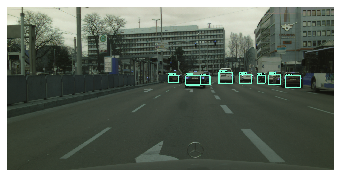

Completed current frame in: 1.974 seconds. % (Total: 1.974 secconds)


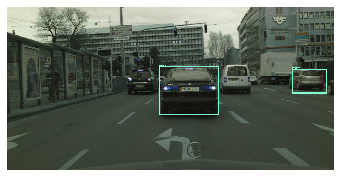

Completed current frame in: 0.017 seconds. % (Total: 1.991 secconds)


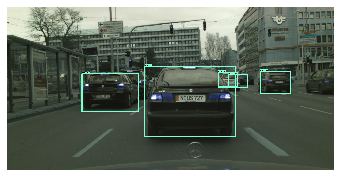

Completed current frame in: 0.017 seconds. % (Total: 2.008 secconds)


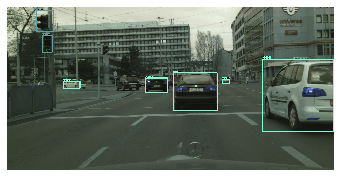

Completed current frame in: 0.032 seconds. % (Total: 2.040 secconds)


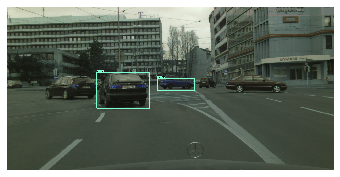

Completed current frame in: 0.021 seconds. % (Total: 2.060 secconds)


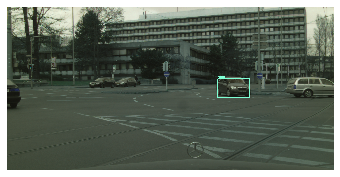

Completed current frame in: 0.038 seconds. % (Total: 2.098 secconds)


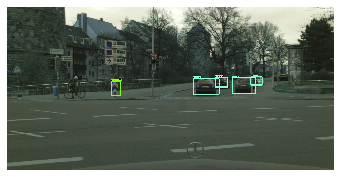

Completed current frame in: 0.051 seconds. % (Total: 2.149 secconds)


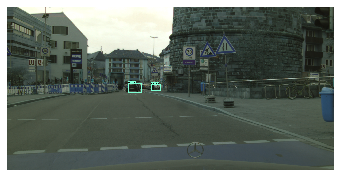

Completed current frame in: 0.021 seconds. % (Total: 2.170 secconds)


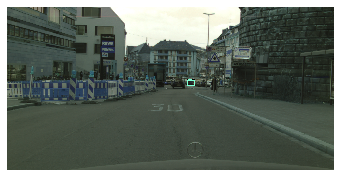

Completed current frame in: 0.021 seconds. % (Total: 2.191 secconds)


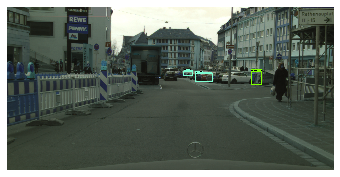

Completed current frame in: 0.045 seconds. % (Total: 2.236 secconds)


In [24]:
PATH_TO_LABELS = 'tensorrt/coco/mscoco_label_map.pbtxt'
PATH_TO_TEST_IMAGES_DIR = 'tensorrt/coco/CS' #Change the dataset and view the detections
OUT_PATH = 'temp'

detect_frames(PATH_TO_LABELS, PATH_TO_TEST_IMAGES_DIR, OUT_PATH)

Note the time spent on the inference. Also notice that here we are feeding images individually. The `for` loop within the `detect_frames` function, reads one image at a time and pass it through the inference session. In Exercise 5, you are asked to run the inference on a batch size of 32 and compare the results with single image inference.


### Optimization

Now we are moving to the optimization step:


In [25]:
# optimize model using source model
frozen_graph_optimized = optimize_model(
    config_path=config_path,
    checkpoint_path=checkpoint_path,
    **test_config['optimization_config'])

INFO:tensorflow:depth of additional conv before box predictor: 0


I0709 17:53:02.548437 139836305807168 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0709 17:53:02.609401 139836305807168 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0709 17:53:02.676630 139836305807168 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0709 17:53:02.737018 139836305807168 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0709 17:53:02.880228 139836305807168 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0709 17:53:02.941295 139836305807168 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0


Instructions for updating:
Please switch to tf.train.get_or_create_global_step


W0709 17:53:05.199030 139836305807168 deprecation.py:323] From /home/jylee/work/tensorflow/models/research/object_detection/exporter.py:348: get_or_create_global_step (from tensorflow.contrib.framework.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step


Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details


W0709 17:53:05.202260 139836305807168 deprecation.py:323] From /home/jylee/work/tensorflow/models/research/object_detection/exporter.py:504: print_model_analysis (from tensorflow.contrib.tfprof.model_analyzer) is deprecated and will be removed after 2018-01-01.
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details


Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


W0709 17:53:05.203875 139836305807168 deprecation.py:323] From /home/jylee/.local/lib/python3.6/site-packages/tensorflow/python/profiler/internal/flops_registry.py:142: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
18 ops no flops stats due to incomplete shapes.
18 ops no flops stats due to incomplete shapes.


INFO:tensorflow:Restoring parameters from models/ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt


I0709 17:53:08.334670 139836305807168 saver.py:1270] Restoring parameters from models/ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt


INFO:tensorflow:Restoring parameters from models/ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt


I0709 17:53:10.835335 139836305807168 saver.py:1270] Restoring parameters from models/ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt


INFO:tensorflow:Froze 404 variables.


I0709 17:53:11.890605 139836305807168 graph_util_impl.py:268] Froze 404 variables.


INFO:tensorflow:Converted 404 variables to const ops.


I0709 17:53:11.969227 139836305807168 graph_util_impl.py:301] Converted 404 variables to const ops.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


W0709 17:53:13.554883 139836305807168 deprecation.py:323] From /home/jylee/work/tensorflow/models/research/object_detection/exporter.py:277: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.


I0709 17:53:13.555938 139836305807168 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0709 17:53:13.556555 139836305807168 builder_impl.py:449] No assets to write.


INFO:tensorflow:SavedModel written to: .optimize_model_tmp_dir/saved_model/saved_model.pb


I0709 17:53:13.976054 139836305807168 builder_impl.py:414] SavedModel written to: .optimize_model_tmp_dir/saved_model/saved_model.pb


INFO:tensorflow:Writing pipeline config file to .optimize_model_tmp_dir/pipeline.config


I0709 17:53:14.019027 139836305807168 config_util.py:186] Writing pipeline config file to .optimize_model_tmp_dir/pipeline.config


W0709 17:53:14.250206 139836305807168 tf_logging.py:161] TensorRT mismatch. Compiled against version 5.0.2, but loaded 5.1.5. Things may not work


### Post-Optimization Run:

Finally, we load the saved optimized graph using tf.gfile.GFile and run the detect frames procedure:

In [26]:
path_to_graph = join('models', models[test_config['source_model']['model_name']].extract_dir,
                              'frozen_inference_graph.pb') 
# Import a graph by reading it as a string, parsing this string then importing it using the tf.import_graph_def command
print('Importing graph...')
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(path_to_graph, 'rb') as fid:
        tf.import_graph_def(frozen_graph_optimized, name='')
print('Importing graph completed')

Importing graph...
Importing graph completed


Starting session...
Running Inference:


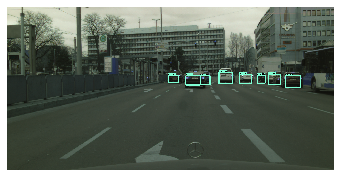

Completed current frame in: 0.584 seconds. % (Total: 0.584 secconds)


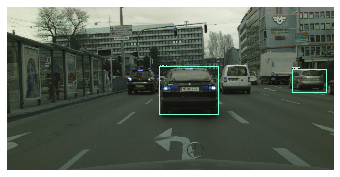

Completed current frame in: 0.007 seconds. % (Total: 0.591 secconds)


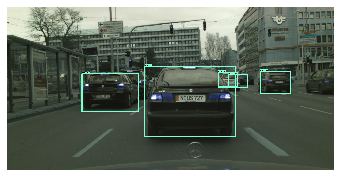

Completed current frame in: 0.008 seconds. % (Total: 0.598 secconds)


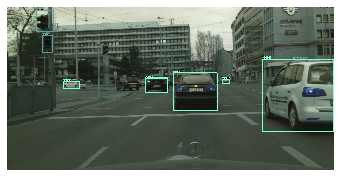

Completed current frame in: 0.006 seconds. % (Total: 0.605 secconds)


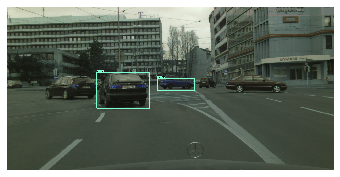

Completed current frame in: 0.007 seconds. % (Total: 0.612 secconds)


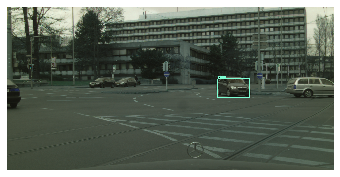

Completed current frame in: 0.007 seconds. % (Total: 0.618 secconds)


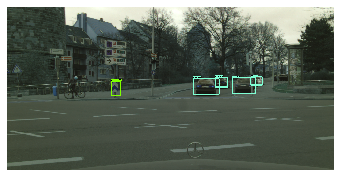

Completed current frame in: 0.007 seconds. % (Total: 0.626 secconds)


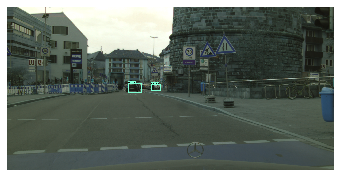

Completed current frame in: 0.007 seconds. % (Total: 0.633 secconds)


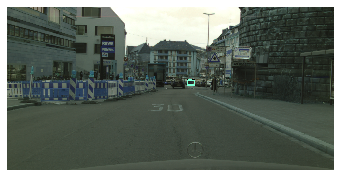

Completed current frame in: 0.007 seconds. % (Total: 0.639 secconds)


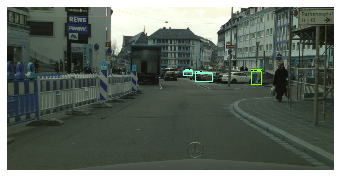

Completed current frame in: 0.007 seconds. % (Total: 0.647 secconds)


In [27]:
PATH_TO_LABELS = 'tensorrt/coco/mscoco_label_map.pbtxt'
PATH_TO_TEST_IMAGES_DIR = 'tensorrt/coco/CS' #Change the dataset and view the detections
OUT_PATH = 'temp'

detect_frames(PATH_TO_LABELS, PATH_TO_TEST_IMAGES_DIR, OUT_PATH)

How do you compare the results of the optimized model to the non-optimized version? Can you distinguish any visual difference?

<a id='exercise_4'></a>
### Exercise 4: SSD MobileNet Optimization
---

Repeat the benchmarking for the __ssd_mobilenet_v1_ppn_coco__ model and compare the speed up gains. To achieve that, you need to open the [model_config.json](../../../../edit/tasks/l-iv-07-v2/task/tensorrt/model_config.json) file and modify `model_name`, `image_shape` and `output_path` parameters. Afterwards, follow the same steps as `ssdlite_mobilenet_v2_coco` model and compare the results. 

* __Note:__ When you make changes to the JSON file, remember to save them by selecting `file` from the menu and clicking on the `save` button.

In [ ]:
Your answer:

<a id='exercise_5'></a>
### Exercise 5: Batch Inference
---

Previously, within the classification task, we saw how choosing a proper `batch size` could affect the classification time . In our detection example, we simulated a case where data feed is live and sourced from a single camera (we processed one image at a time during each run of the `tf.session` object). While the time improvement was again significant, we can do better if we optimize and then infer images in __batches__. Consider a case where you have multiple cameras, and at each epoch, several frames are queued and fed into your inference engine. 
In this exercise, you will have to modify the optimization for batch sizes of 16 and 32 and then modify the detect frames to perform inference in batches of the same size and then compare the inference time improvement over a single frame inference.

In [ ]:
# PERFORM THE COMPARISON HERE (average inference time):

Batch \ Precision |
size              |      FP16             FP32
------------------------------------------------------------
                  |
1 (summed         |
  over 32 runs)   |
                  |
                  |
32  (single run)  |
                  |               

<a id='summary'></a>
## Summary

Congratulations on completing the __Deep Learning Optimization and Deployment using TensorRT__! If you have any spare time left, please alter the script above to experiment with models from the following list:

  - ssd_mobilenet_v1_0p75_depth_quantized_coco
       
  - ssd_mobilenet_v1_ppn_coco

  - ssd_mobilenet_v2_coco

  - ssdlite_mobilenet_v2_coco

  - ssd_inception_v2_coco

  - ssd_resnet_50_fpn_coco

  - faster_rcnn_resnet50_coco

  - faster_rcnn_nas

  - mask_rcnn_resnet50_atrous_coco

  - facessd_mobilenet_v2_quantized_open_image_v4



__What we have learned;__

* The fundamentals of optimization using TF-TRT
* Deploying deep learning models by reduced precision (FP32, FP16 and INT8) on the inference stage and how to calibrate the weights according to data distribution
* Benchmarking classification and detection models over the desired dataset after optimization
* Implementing custom operations to include non-supported operations


We hope to see you in future courses where you can learn more about usage of the optimized models in real-life applications like Intelligent Video Analytics, Natural Language Processing and Healthcare.

### More Readings...
<br/>

In the following blog post, you will learn how to deploy a deep learning application onto a GPU, increasing throughput and reducing latency during inference:

1. [How to Speed Up Deep Learning Inference Using TensorRT](https://devblogs.nvidia.com/speed-up-inference-tensorrt/)

In the next blog post, it is shown how TensorRT Integration specifically Speeds Up TensorFlow Inference:

2. [TensorRT Integration Speeds Up TensorFlow Inference](https://devblogs.nvidia.com/tensorrt-integration-speeds-tensorflow-inference/)

The following blog post, introduces TensorRT as a high-performance deep learning inference library for production environments:
3. [Deploying Deep Neural Networks with NVIDIA TensorRT](https://devblogs.nvidia.com/deploying-deep-learning-nvidia-tensorrt/)

Official documentation on how to accelerate inference in TensorFlow with TensorRT (TF-TRT):

4. [TF-TRT Documentation](https://docs.nvidia.com/deeplearning/dgx/integrate-tf-trt/index.html)

TensorRT Developer Guide:

5. [NVIDIA TensorRT - Developer Guide](https://developer.nvidia.com/tensorrt)

The following video demonstrates how to configure a simple Recurrent Neural Network (RNN) based on the character-level language model using NVIDIA TensorRT:

6. [Video: Introduction to Recurrent Neural Networks in TensorRT](https://devblogs.nvidia.com/video-introduction-to-recurrent-neural-networks-in-tensorrt/)

<a id="solution"></a>
### Solution

#### exercise 3

In [ ]:
p_mode = 'INT8'

trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=32,
    max_workspace_size_bytes=1 << 25,
    precision_mode=p_mode,
    minimum_segment_size=50)

In [ ]:
tf.reset_default_graph()
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)
tf.import_graph_def(trt_graph, name='')
tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_output = tf_sess.graph.get_tensor_by_name(output_names[0] + ':0')

In [ ]:
run_test(32)

In [ ]:
calibrated_model = trt.calib_graph_to_infer_graph(trt_graph)

In [ ]:
tf.reset_default_graph()

tf_sess = tf.Session(config=tf_config)
tf.import_graph_def(calibrated_model, name='')
tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_output = tf_sess.graph.get_tensor_by_name(output_names[0] + ':0')

In [ ]:
run_test(32) #SLOW!!

In [ ]:
run_test(32) #FAST!!

Click [here](#exercise_3) to go back